In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
# Crear un directorio y mover el archivo `kaggle.json` allí.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Cambiar los permisos del archivo.
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d  phucthaiv02/butterfly-image-classification

Dataset URL: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification
License(s): CC0-1.0
 99% 223M/226M [00:08<00:00, 41.0MB/s]
100% 226M/226M [00:08<00:00, 29.3MB/s]


In [ ]:
!unzip butterfly-image-classification.zip


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train/Image_2348.jpg    
  inflating: train/Image_2349.jpg    
  inflating: train/Image_235.jpg     
  inflating: train/Image_2350.jpg    
  inflating: train/Image_2351.jpg    
  inflating: train/Image_2352.jpg    
  inflating: train/Image_2353.jpg    
  inflating: train/Image_2354.jpg    
  inflating: train/Image_2355.jpg    
  inflating: train/Image_2356.jpg    
  inflating: train/Image_2357.jpg    
  inflating: train/Image_2358.jpg    
  inflating: train/Image_2359.jpg    
  inflating: train/Image_236.jpg     
  inflating: train/Image_2360.jpg    
  inflating: train/Image_2361.jpg    
  inflating: train/Image_2362.jpg    
  inflating: train/Image_2363.jpg    
  inflating: train/Image_2364.jpg    
  inflating: train/Image_2365.jpg    
  inflating: train/Image_2366.jpg    
  inflating: train/Image_2367.jpg    
  inflating: train/Image_2368.jpg    
  inflating: train/Image_2369.jpg    
  inflating: train/Image_23

In [ ]:
import cv2

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from datetime import datetime
import os

#!pip install tqdm
from tqdm.notebook import tqdm



In [ ]:
def resize_image(image, size):
    h,w,c = image.shape

    if h > w:
        w = int(size*w/h)
        h = size
    else:
        h = int(size*h/w)
        w = size
    new_image = np.zeros((size, size, 3), dtype=np.uint8)

    image = cv2.resize(image, (w, h))
    new_image[0:h, 0:w, :] = image
    return new_image

In [ ]:
import torch

# Verifica si CUDA está disponible y asigna el dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")


Using GPU: Tesla T4


In [ ]:
import torch
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))


0
1
Tesla T4


In [ ]:
# Comando para ver el uso de la memoria en la GPU
!nvidia-smi


Sat May 11 18:06:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Supongamos que tienes un tensor 'a'
a = torch.tensor([1.0, 2.0, 3.0], device=device)  # 'device' es 'cuda' si la GPU está disponible

# Puedes verificar si 'a' está en GPU
print("Is tensor 'a' on GPU?:", a.is_cuda)


Is tensor 'a' on GPU?: True


In [ ]:
# Clase para la extracción de características usando VGG19
class FeatureExtractor:
     def __init__(self, device):
        self.device = device  # Guardar la referencia al dispositivo
        self.model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
        self.model.to(device)  # Mueve el modelo al dispositivo
        self.max_pooling_indices = [9, 18, 27, 36]
        self.model.eval()

     @torch.no_grad()
     def extract_feature_vector(self, x, stage=0, verbose=False):
        for i, feature in enumerate(self.model.features):
            if verbose:
                print(f"Input device: {x.device}, Model device: {next(self.model.parameters()).device}")
                print(f'Passing through layer {type(feature)}')
            if i == self.max_pooling_indices[stage]:
                return x
            x = feature(x)

In [ ]:
# Función para preprocesar y extraer características de todas las imágenes
def extract_features(dataframe, image_dir, device):
    feature_vectors = []
    labels = []
    for index, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        image_name = row['filename']
        label_name = row['label']
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path)
        if image.mode in ['RGBA', 'L', 'P']:
            image = image.convert('RGB')
        image = np.array(image)[...,::-1]
        image = resize_image(image, 255)
        transformed_image = backbone_transforms(image).unsqueeze(0).to(device)
        feature_vector = fe.extract_feature_vector(transformed_image, 1).flatten().cpu().numpy()


        feature_vectors.append(feature_vector)
        labels.append(label_name)
    return np.array(feature_vectors), np.array(labels)






In [ ]:
# Transformaciones de imágenes para prepararlas para VGG19
backbone_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Leer el DataFrame de las imágenes

train_img_dir = './train'
train_csv_file = 'Training_set.csv'
train_df = pd.read_csv(train_csv_file)

# Extraer características
fe = FeatureExtractor(device)
feature_vectors, labels = extract_features(train_df, train_img_dir, device)

  0%|          | 0/6499 [00:00<?, ?it/s]

In [ ]:
print("Device:", device)  # Debería mostrar 'cuda' si la GPU está disponible y seleccionada


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Asegúrate de que el dispositivo seleccionado se pasa a la clase FeatureExtractor
fe = FeatureExtractor(device)



Using device: cuda


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fe = FeatureExtractor(device)  # Asegúrate de que 'device' se pasa correctamente


              precision    recall  f1-score   support

           0       0.31      0.78      0.44        23
           1       0.74      0.71      0.72        24
           2       0.18      0.21      0.20        19
           3       0.60      0.90      0.72        20
           4       0.50      0.61      0.55        28
           5       0.21      0.52      0.30        27
           6       0.48      0.47      0.47        30
           7       0.47      0.41      0.44        22
           8       0.23      0.17      0.20        29
           9       0.47      0.67      0.55        30
          10       0.75      0.29      0.41        21
          11       0.38      0.42      0.40        26
          12       0.63      0.45      0.52        38
          13       0.33      0.57      0.41        30
          14       0.45      0.74      0.56        23
          15       0.43      0.42      0.43        31
          16       0.57      0.44      0.50        27
          17       0.38    

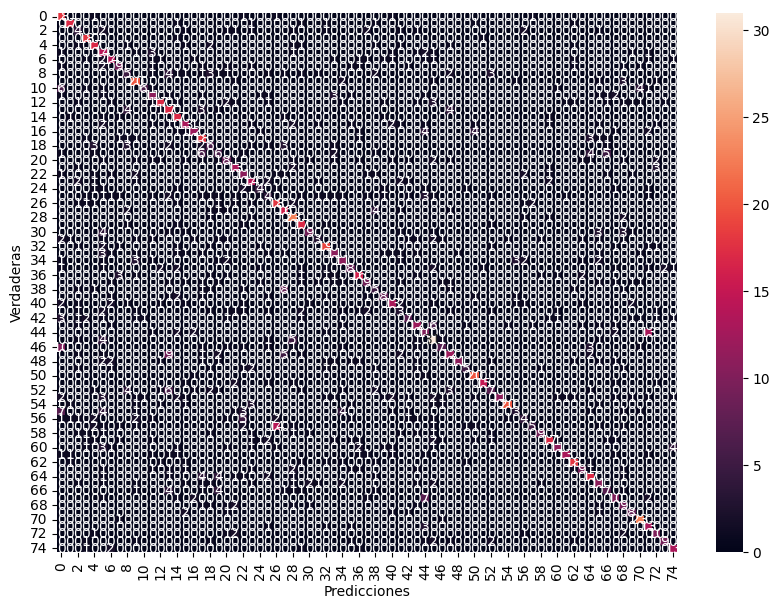

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir etiquetas de texto a índices numéricos
label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}
numeric_labels = np.array([label_to_index[label] for label in labels])

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, numeric_labels, test_size=0.3, random_state=42)

# Entrenar modelo de Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Evaluar el modelo
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))


from sklearn.metrics import accuracy_score

# Calcular la precisión
accuracy = accuracy_score(y_test, predictions)

# Imprimir la precisión
print("Accuracy: {:.2f}%".format(accuracy * 100))


# Matriz de confusión
# cm = confusion_matrix(y_test, predictions)
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d')
# plt.xlabel('Predicciones')
# plt.ylabel('Verdaderas')
# plt.show()


In [ ]:
!pip install psutil
import psutil

# Obtener la memoria total y la memoria disponible
memory = psutil.virtual_memory()
print(f"Total memory: {memory.total / (1024**3):.2f} GB")
print(f"Available memory: {memory.available / (1024**3):.2f} GB")
print(f"Used memory: {memory.used / (1024**3):.2f} GB")
print(f"Memory usage: {memory.percent}%")


Total memory: 50.99 GB
Available memory: 49.28 GB
Used memory: 1.18 GB
Memory usage: 3.4%


In [ ]:
!pip install gpustat
!gpustat


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.2 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.1.1-py3-none-any.whl size=26532 sha256=917c1518b5017eea36d8f47585cd5b561f9249273abf51b020ce21bb8f41ca12
  Stored in directory: /root/.cache/pip/wheels/ec/d7/80/a71ba3540900e1f276bcae685efd8e590c810d2108b95f1e47
Successfully built gpustat
8d01a60139aa  Sat May 11 15:06:31 2024  535.104.05
[0] Tesla T4 | 57°C,   0 % |     0 / 15360 MB |
